In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import warnings

%matplotlib inline

# 한글 설정
import matplotlib.font_manager as fm

warnings.filterwarnings(action='ignore')
        
font_name = fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
plt.rc('font', family=font_name)

## 영화 데이터
- 필요한 이유: 사용자에게 영화를 추천해주기 위해 데이터가 필요하였음
- 활용 방안: 영화 줄거리를 활용하여 감정분석하고 사용자 감정과 일치/대립하는 영화를 추천하는 방향으로 데이터 활용

In [67]:
data = pd.read_csv("data/af_kmdb.csv", usecols=['영화명', '유형', '장르', '제작년도', '감독', '출연', '줄거리'])
data.head(3)

,영화명,유형,장르,제작년도,감독,출연,줄거리
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"코메디,멜로드라마",2010.0,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,액션,2011.0,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"
2,넥스트 어벤져 : 히어로 오브 투모로우,애니메이션,"액션,어드벤처",2012.0,"제이 올리바,개리 해틀","그레그 존슨,크랙 카일","어벤져,아이언맨,출생의비밀,헐크"


In [68]:
data = data.rename(columns={'영화명':'title', '유형':'category', '장르':'genre', 
                            '제작년도':'year', '감독':'direct', '출연':'actors', '줄거리':'content'})

### 1. 분포 확인

#### 결측치 확인

In [69]:
data.isna().sum()

title          0
category       0
genre       1153
year           0
direct       560
actors      7942
content        0
dtype: int64

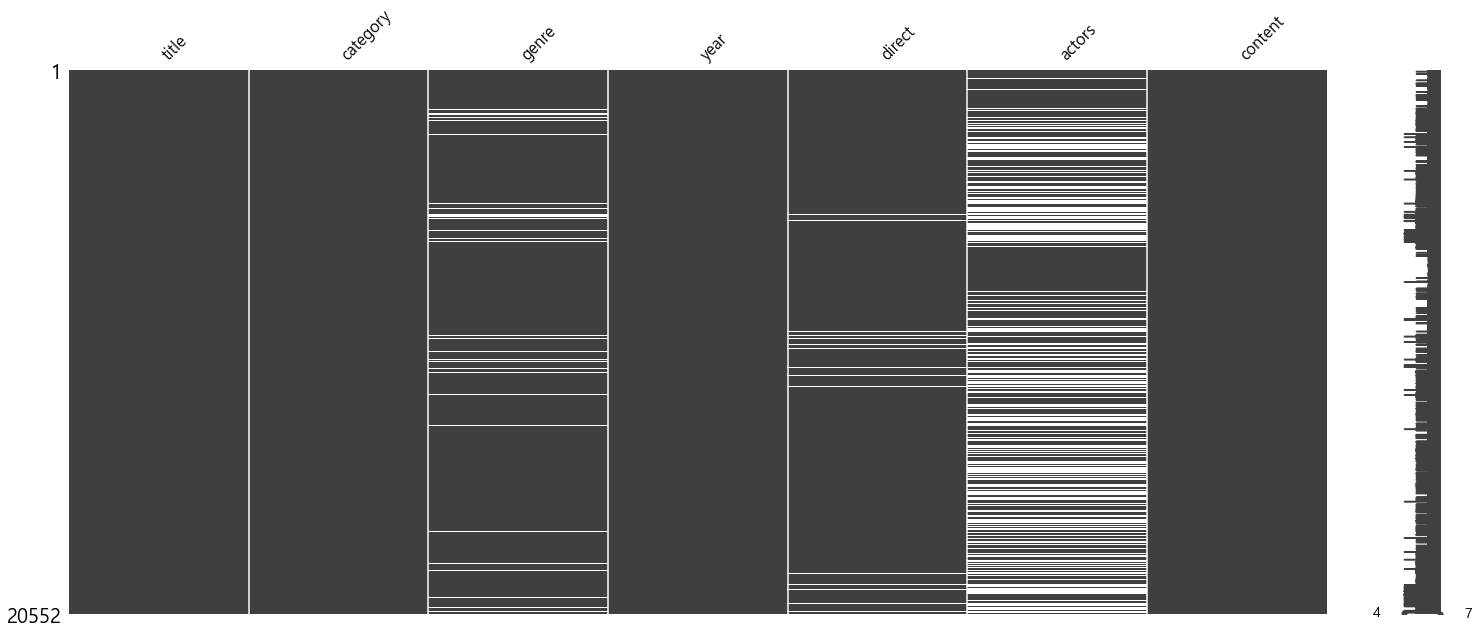

In [4]:
msno.matrix(data)
plt.show()

- 장르: 추천 시스템 내 중요 변수로 판단 → 따라서, 결측값 제거

In [70]:
data_na = data.dropna(subset=['genre'], axis=0)
data_na.head()

,title,category,genre,year,direct,actors,content
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"코메디,멜로드라마",2010.0,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,액션,2011.0,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"
2,넥스트 어벤져 : 히어로 오브 투모로우,애니메이션,"액션,어드벤처",2012.0,"제이 올리바,개리 해틀","그레그 존슨,크랙 카일","어벤져,아이언맨,출생의비밀,헐크"
3,가십 걸 시즌 1,TV-시리즈,"코메디,멜로드라마",2007.0,마크 피즈나스키,스테파니 세비지,"데이트,사랑과우정,사립학교,상류사회,파티,연애담,가십,뉴욕"
4,스콧 필그림,극영화,"액션,코메디,멜로드라마,판타지",2010.0,에드가 라이트,"에드가 라이트,마이클 바콜","토론토,록밴드,이상형,데이트,결투,전남자친구"


#### 1) 장르 분포

In [71]:
# 장르 내 불필요 단어 제거
data_na['genre'] = data_na['genre'].apply(lambda x: re.sub(r'\(.*\)*', "", x))

# 장르: , -> 리스트 변환
data_na['genre'] = data_na['genre'].apply(lambda x:list(x.split(",")))

In [72]:
# 모든 장르 정보 수집
genres = []
for row in data_na['genre']:
    genres.extend(row)

In [73]:
np.unique(genres)

array(['SF', 'TV드라마', '가족', '갱스터', '계몽', '공포', '과학', '교육', '군사',
       '기독교 애니메이션', '기록', '기업ㆍ기관ㆍ단체', '느와르', '다부작', '동성애', '드라마', '로드무비',
       '로맨스', '멜로', '멜로/로맨스', '멜로드라마', '모험', '무협', '문화', '뮤지컬', '뮤직',
       '미스터리', '반공/분단', '범죄', '사회', '사회물', '서부', '스릴러', '스포츠', '시대극/사극',
       '신파', '실험', '아동', '애니매에이션', '애니메이션', '애정', '액션', '어드벤처', '에로',
       '역사', '예술', '오페라', '옴니버스', '인권', '인물', '자연ㆍ환경', '재난', '전기', '전쟁',
       '종교', '지역', '첩보', '청춘영화', '코메디', '판타지', '하이틴', '합작', '해양액션', '활극'],
      dtype='<U9')

In [74]:
from collections import Counter

cnt_gr = Counter(genres)

# 공통 장르 묶기
cnt_gr['로맨스'] += cnt_gr['멜로'] + cnt_gr['멜로/로맨스'] + cnt_gr['멜로드라마']
del cnt_gr['멜로']; del cnt_gr['멜로/로맨스']; del cnt_gr['멜로드라마']

In [75]:
# 장르 top10 선정
top10_genre = cnt_gr.most_common(10)
top10 = [g for g, _ in top10_genre]
top10 

['드라마', '코메디', '액션', '스릴러', '로맨스', '판타지', '공포', '어드벤처', '범죄', '가족']

In [76]:
# top10+기타 누락 장르 묶기
others_cnt = sum([v for k, v in dict(cnt_gr).items() if k not in top10])

top10_genre.append(("기타", others_cnt))
top10_genre

[('드라마', 10679),
 ('코메디', 2884),
 ('액션', 2526),
 ('스릴러', 1958),
 ('로맨스', 1621),
 ('판타지', 1197),
 ('공포', 1142),
 ('어드벤처', 1088),
 ('범죄', 1015),
 ('가족', 1014),
 ('기타', 8844)]

In [77]:
# 재정렬
top10_genre.sort(key = lambda x:x[1], reverse=True)
top10_genre[:3]

[('드라마', 10679), ('기타', 8844), ('코메디', 2884)]

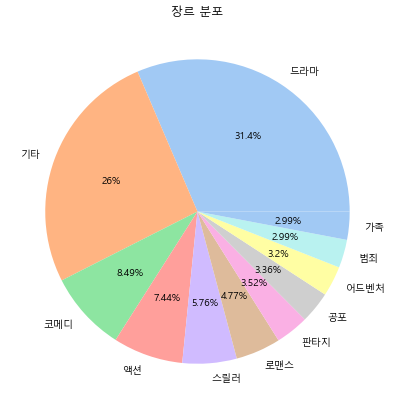

In [33]:
plt.figure(figsize = (7, 7))

colors = sns.color_palette('pastel', len([g for g, _ in top10_genre]))
plt.pie([c for _, c in top10_genre], labels=[g for g, _ in top10_genre], autopct="%1.3g%%", colors = colors)

plt.title("장르 분포")
plt.show()

- 영화 장르 분포를 살펴본 결과, 드라마 장르가 30%였으며 코메디가 8.5%를 차지하였다.
    - 드라마 장르: 실제 드라마와 같이 스토리가 주가되며 현실적인 이야기, 가족, 성장기, 사랑 등 다양한 장르를 포함하는 이야기
- 추천 서비스를 제공할 때, 장르를 사용한다면 드라마(모호한 분류)와 기타(비주류)를 제외하고 9가지 중 적절한 것을 제공하도록 설정

#### 2) 카테고리 분포

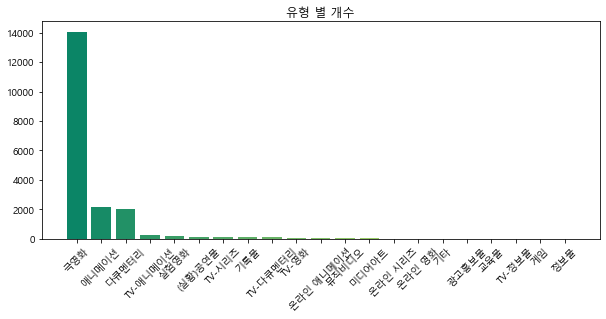

In [34]:
cate_cnt = data_na["category"].value_counts()

fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(cate_cnt))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels(cate_cnt.index, rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('summer', len(cate_cnt)) # 바 차트 색상
ax1.bar(xtick_label_position, cate_cnt.values, color=colors) # 바차트 출력

plt.title("유형 별 개수")
plt.show()

- 대부분 극영화, 애니메이션, 다큐멘터리 3개로 구성됨 → 유사 장르는 하나로 묶고 그 외 비주류 제거
- top3과 유사 장르 하나로 묶기
    - 애니메이션: TV-애니메이션, 온라인 애니메이션
    - 영화: TV-영화, 실험영화, 온라인 영화
    - 다큐멘터리: TV-다큐멘터리, TV-정보물, 정보물

In [78]:
data_na['category'] = data_na['category'].replace({'TV-애니메이션':'애니메이션', '온라인 애니메이션':'애니메이션', 
                                                    'TV-영화':'영화', '실험영화':'영화', '온라인 영화':'영화',
                                                    'TV-다큐멘터리':'다큐멘터리', 'TV-정보물':'다큐멘터리', '정보물':'다큐멘터리'})

In [79]:
data_na = data_na[data_na['category'].isin(['극영화', '애니메이션', '다큐멘터리'])].reset_index(drop=True)
data_na = data_na.astype({"year":int})
data_na.head()

,title,category,genre,year,direct,actors,content
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"[코메디, 멜로드라마]",2010,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,[액션],2011,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"
2,넥스트 어벤져 : 히어로 오브 투모로우,애니메이션,"[액션, 어드벤처]",2012,"제이 올리바,개리 해틀","그레그 존슨,크랙 카일","어벤져,아이언맨,출생의비밀,헐크"
3,스콧 필그림,극영화,"[액션, 코메디, 멜로드라마, 판타지]",2010,에드가 라이트,"에드가 라이트,마이클 바콜","토론토,록밴드,이상형,데이트,결투,전남자친구"
4,복수자,극영화,"[액션, 드라마, 범죄, 스릴러]",2010,조지 틸만 주니어,"토니 게이튼,조 게이튼","은행털이,감옥,복수,은퇴,형사,킬러"


#### 3) 극 영화 장르 분포

In [80]:
film = data_na[data_na['category'] == '극영화']

# 모든 장르 정보 수집
film_genres = []
for row in film['genre']:
    film_genres.extend(row)

In [81]:
film_gr = Counter(film_genres)

# 공통 장르 묶기
film_gr['로맨스'] += film_gr['멜로'] + film_gr['멜로/로맨스'] + film_gr['멜로드라마']
del film_gr['멜로']; del film_gr['멜로/로맨스']; del film_gr['멜로드라마']

In [82]:
# top10+기타 누락 장르 묶기
others_cnt = sum([v for k, v in dict(film_gr).items() if k not in top10])

film_top10 = [(k, v) for k, v in dict(film_gr).items() if k in top10]
film_top10.append(("기타", others_cnt))
film_top10.sort(key = lambda x:x[1], reverse=True)

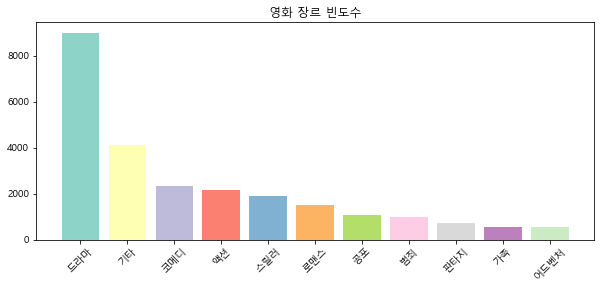

In [41]:
fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(film_top10))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels([g for g, _ in film_top10], rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('Set3', len(film_top10)) # 바 차트 색상
ax1.bar(xtick_label_position, [c for _, c in film_top10], color=colors) # 바차트 출력

plt.title("영화 장르 빈도수")
plt.show()

- 극 영화는 드라마 장르가 가장 많았으며 기타를 제외하고는 코메디, 액션 순으로 장르가 많았다.

#### 4) 애니메이션 장르 분포

In [83]:
ani = data_na[data_na['category'] == '애니메이션']

# 모든 장르 정보 수집
ani_genres = []
for row in ani['genre']:
    ani_genres.extend(row)

In [84]:
ani_genres[:10]

['액션', '어드벤처', '액션', '액션', '어드벤처', '멜로드라마', '어드벤처', '판타지', '어드벤처', '코메디']

In [85]:
ani_gr = Counter(ani_genres)

# 공통 장르 묶기
ani_gr['로맨스'] += ani_gr['멜로'] + ani_gr['멜로/로맨스'] + ani_gr['멜로드라마']
del ani_gr['멜로']; del ani_gr['멜로/로맨스']; del ani_gr['멜로드라마']

In [86]:
# top10+기타 누락 장르 묶기
others_cnt = sum([v for k, v in dict(ani_gr).items() if k not in top10])

ani_top10 = [(k, v) for k, v in dict(ani_gr).items() if k in top10]
ani_top10.append(("기타", others_cnt))
ani_top10.sort(key = lambda x:x[1], reverse=True)

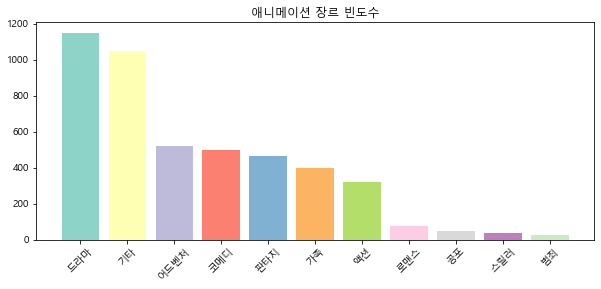

In [46]:
fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(ani_top10))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels([g for g, _ in ani_top10], rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('Set3', len(ani_top10)) # 바 차트 색상
ax1.bar(xtick_label_position, [c for _, c in ani_top10], color=colors) # 바차트 출력

plt.title("애니메이션 장르 빈도수")
plt.show()

- 애니메이션도 영화와 같이 드라마 장르가 가장 많았으며 기타를 제외하고는 어드벤처, 코메디, 판타지 순으로 장르가 분포하였다.
- 극영화의 대상에 비하여 애니메이션의 대상은 아동 위주가 많기 때문에 영화와 다른 분포를 보이는 것으로 판단된다.

#### 5) 다큐멘터리 장르 분포

In [87]:
docu = data_na[data_na['category'] == '다큐멘터리']

# 모든 장르 정보 수집
docu_genres = []
for row in docu['genre']:
    docu_genres.extend(row)

In [88]:
docu_genres[:10]

['사회', '인물', '사회', '인권', '드라마', '사회', '인물', '문화', '드라마', '사회물']

In [89]:
doc_gr = Counter(docu_genres)

# 공통 장르 묶기
doc_gr['로맨스'] += doc_gr['멜로'] + doc_gr['멜로/로맨스'] + doc_gr['멜로드라마']
del doc_gr['멜로']; del doc_gr['멜로/로맨스']; del doc_gr['멜로드라마']

In [90]:
# top10+기타 누락 장르 묶기
others_cnt = sum([v for k, v in dict(doc_gr).items() if k not in top10])

docu_top10 = [(k, v) for k, v in dict(doc_gr).items() if k in top10]
docu_top10.append(("기타", others_cnt))
docu_top10.sort(key = lambda x:x[1], reverse=True)

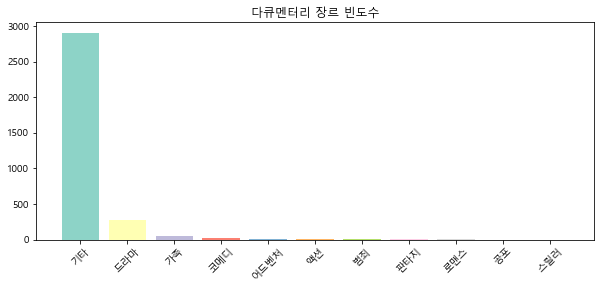

In [51]:
fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(docu_top10))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels([g for g, _ in docu_top10], rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('Set3', len(docu_top10)) # 바 차트 색상
ax1.bar(xtick_label_position, [c for _, c in docu_top10], color=colors) # 바차트 출력

plt.title("다큐멘터리 장르 빈도수")
plt.show()

- 다큐멘터리는 top10 장르보다 기타 장르가 많으며 타 장르는 현저하게 적은 분포를 보인다.
- 다큐멘터리를 지우기보다는 기타 장르만을 포함하는 다큐멘터리는 제거하는 방향으로 전처리 진행

#### 6) 연도 분포

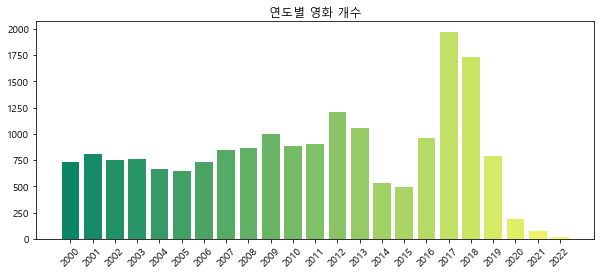

In [29]:
year_cnt = data_na['year'].value_counts().sort_index()

fig = plt.figure(figsize=(10,4)) # Figure 생성 
fig.set_facecolor('white') # Figure 배경색 지정
ax1 = fig.add_subplot() # axes 생성

xtick_label_position = list(range(len(year_cnt))) # x축 눈금 라벨이 표시될 x좌표
ax1.set_xticks(xtick_label_position) # x축 눈금 
ax1.set_xticklabels(year_cnt.index, rotation = 45) # x축 눈금 라벨

colors = sns.color_palette('summer', len(year_cnt)) # 바 차트 색상
ax1.bar(xtick_label_position, year_cnt.values, color=colors) # 바차트 출력

plt.title("연도별 영화 개수")
plt.show()

- 2017, 2018년에 많은 영화가 개봉하였다.

### 2. 영화 내용

In [112]:
from wordcloud import WordCloud
#import nltk
#from konlpy.tag import Okt
from PIL import Image

#### 1) 모든 유형의 영화

In [31]:
# 모든 장르 정보 수집
story = ','.join(list(data_na['content']))
story = story.split(",")

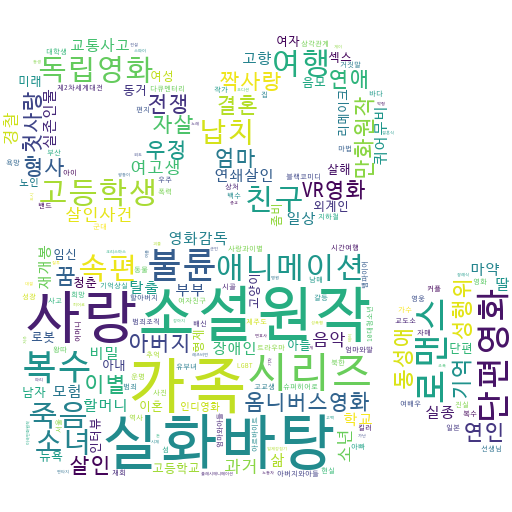

In [32]:
movie_mask = np.array(Image.open("data/movie_logo.png"))
font_path = 'data/D2Coding.ttf'

counter = Counter(story)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(counter)
wc.to_image()

- 실화바탕, 소설원작과 같이 원작이 존재하는 이야기가 많으며 가족, 사랑과 관련된 이야기가 많다.

#### 2) 애니메이션 영화

In [33]:
ani_story = data_na.loc[data_na['category'] == '애니메이션', 'content']
ani_story = ','.join(list(ani_story))
ani_story= ani_story.split(",")

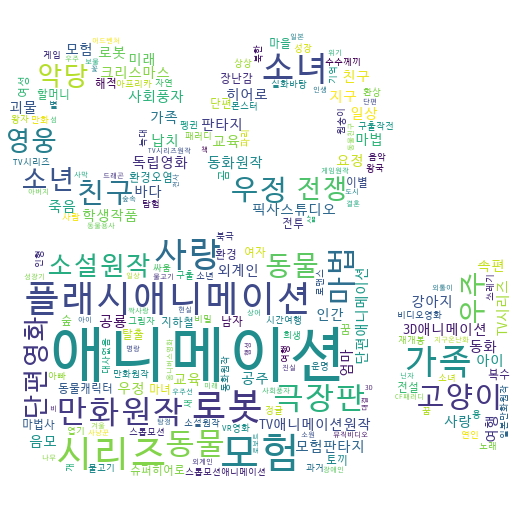

In [34]:
ani_counter = Counter(ani_story)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(ani_counter)
wc.to_image()

- 애니메이션은 만화 원작의 이야기가 많은 것으로 보이고 우정, 가족, 동물 등 집과 관련된 이야기가 많다고 보인다.

#### 3) 극 영화

In [35]:
film_story = data_na.loc[data_na['category'] == '극영화', 'content']
film_story = ','.join(list(film_story))
film_story= film_story.split(",")

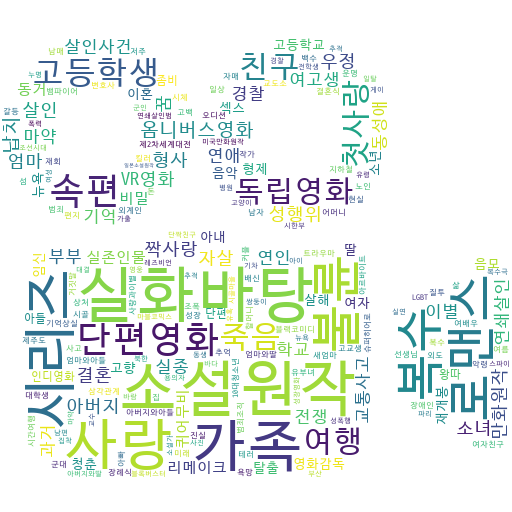

In [36]:
film_counter = Counter(film_story)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(film_counter)
wc.to_image()

#### 4) 다큐멘터리 영화

In [37]:
doc_story = data_na.loc[data_na['category'] == '다큐멘터리', 'content']
doc_story = ','.join(list(doc_story))
doc_story= doc_story.split(",")

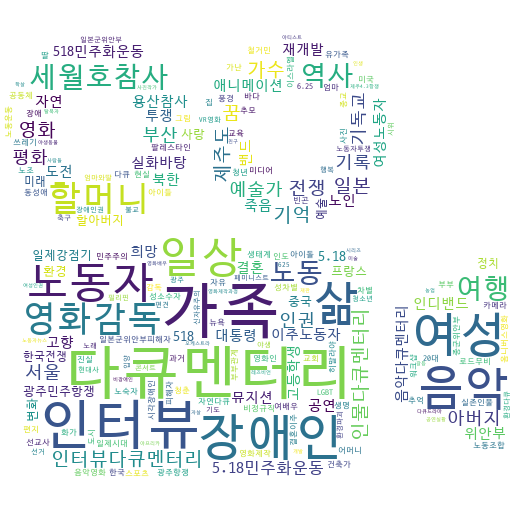

In [38]:
doc_counter = Counter(doc_story)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(doc_counter)
wc.to_image()

- 다큐멘터리는 노동자, 할머니, 가족 등 일상 내 이슈됐던 문제들을 소재로 한 다큐멘터리가 많은 것으로 보인다.

#### 4) 영화가 많이 제작된 2017-2019 트랜드

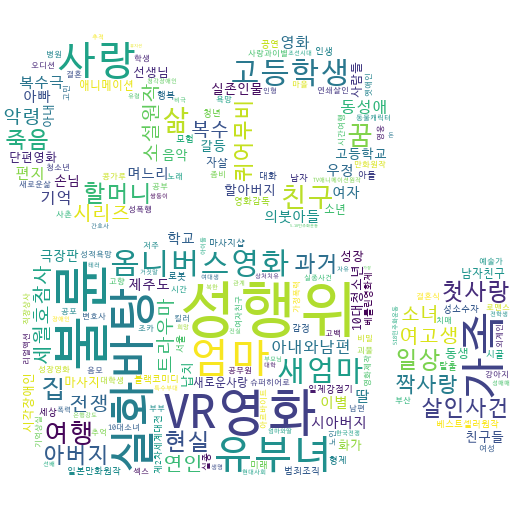

In [39]:
story_2017 = data_na.loc[data_na['year'] == 2017, 'content'] # 2017 컨텐츠만
story_2017 = ','.join(list(story_2017)) # 줄거리 요약 본 전체 합치기
story_2017= story_2017.split(",") # , 기준으로 분리

cnt_2017 = Counter(story_2017) # 단어 개수 카운팅

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(cnt_2017)
wc.to_image()

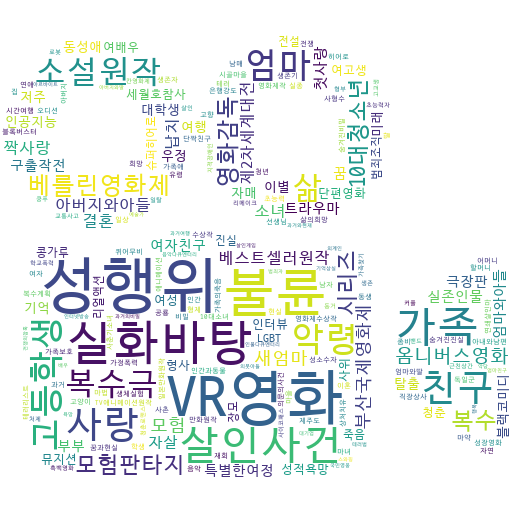

In [40]:
story_2018 = data_na.loc[data_na['year'] == 2018, 'content'] # 2018 컨텐츠만
story_2018 = ','.join(list(story_2018))
story_2018= story_2018.split(",")

story_2018 = Counter(story_2018)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(story_2018)
wc.to_image()

- 영화가 많이 개봉된 2017, 2018년도의 트랜드를 살펴본 결과, 장르가 에로인 컨텐츠의 내용이 많아 전처리 시, 에로 장르의 영화는 제거한다.

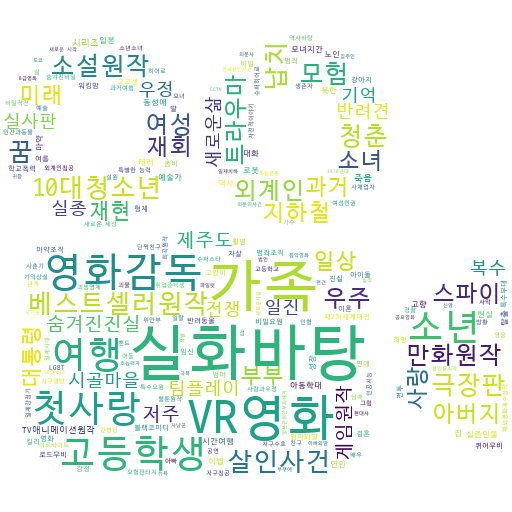

In [41]:
story_2019 = data_na.loc[data_na['year'] == 2019, 'content'] # 2019 컨텐츠만
story_2019 = ','.join(list(story_2019))
story_2019= story_2019.split(",")

story_2019 = Counter(story_2019)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(story_2019)
wc.to_image()

### 불필요 데이터 제거
- 에로 컨텐츠
- top10 장르 외 데이터

#### 1) 에로 컨텐츠 제거

In [91]:
# 애로 제거 - 애로가 있는 데이터 인덱스 찾기
drop_idx = []
for idx, row in data_na.iterrows():
    if '에로' in row['genre']:
        drop_idx.append(idx)

len(drop_idx)

906

In [92]:
# 애로 제거 - 찾은 인덱스 기반으로 행 삭제
data_na = data_na.drop(index = drop_idx).reset_index(drop=True)

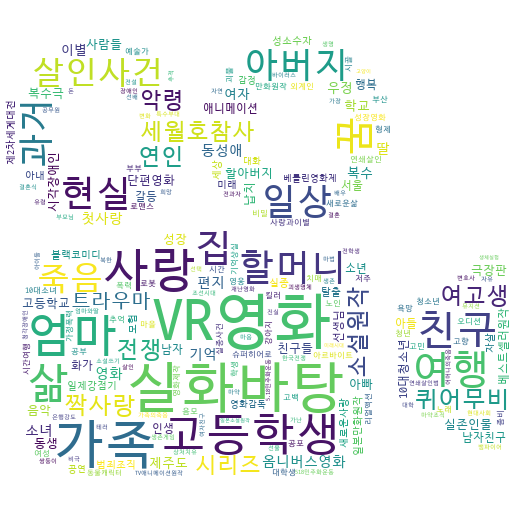

In [44]:
# 제거 후, 2017년 다시 시각화
story_2017 = data_na.loc[data_na['year'] == 2017, 'content']
story_2017 = ','.join(list(story_2017))
story_2017= story_2017.split(",")

cnt_2017 = Counter(story_2017)

wc = WordCloud(background_color="white", max_font_size=60, 
                font_path = font_path, mask=movie_mask)
wc.generate_from_frequencies(cnt_2017)
wc.to_image()

- 에로를 제거한 후, 2017년의 트랜드를 살펴보니, 가족과 관련된 영화가 많았음을 파악할 수 있다.

- 전처리 방향
    - 장르 top10 제외하고 기타 장르는 제거 → top10:['드라마', '코메디', '액션', '스릴러', '로맨스', '판타지', '공포', '어드벤처', '범죄', '가족']
    - 유사 장르는 하나로 묶어 표현: 로맨스 = 로맨스, 멜로, 멜로/로맨스, 멜로드라마

#### 2) top10 항목 외 제거

In [93]:
# 유사 장르 하나로 묶기
same_gr = ['로맨스', '멜로', '멜로/로맨스', '멜로드라마']
for idx, row in data_na.iterrows():
    if len(set(row['genre']) - set(same_gr)) != len(set(row['genre'])): # 유사 장르가 있을 경우,
        data_na.at[idx, 'genre'] = list(set(row['genre']) - set(same_gr))+["로맨스"]

In [96]:
# 장르 내 top10 항목이 있는 영화 True, False
data_na['isTop10'] = data_na['genre'].apply(lambda x: True if len(set(x) - set(top10)) < len(x) else False)

# top10 항목이 있는 영화만 추출
top10_data = data_na[data_na['isTop10']].reset_index(drop=True)
del top10_data['isTop10']
top10_data.head()

,title,category,genre,year,direct,actors,content
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"[코메디, 로맨스]",2010,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,[액션],2011,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"
2,넥스트 어벤져 : 히어로 오브 투모로우,애니메이션,"[액션, 어드벤처]",2012,"제이 올리바,개리 해틀","그레그 존슨,크랙 카일","어벤져,아이언맨,출생의비밀,헐크"
3,스콧 필그림,극영화,"[코메디, 액션, 판타지, 로맨스]",2010,에드가 라이트,"에드가 라이트,마이클 바콜","토론토,록밴드,이상형,데이트,결투,전남자친구"
4,복수자,극영화,"[액션, 드라마, 범죄, 스릴러]",2010,조지 틸만 주니어,"토니 게이튼,조 게이튼","은행털이,감옥,복수,은퇴,형사,킬러"


In [97]:
# 장르 내 top10 외 항목 제거
top10_data['genre'] = top10_data['genre'].apply(lambda x: list(set(top10) - set(set(top10) - set(x))))

# 장르: 리스트 -> , 구분 형태로 변환
top10_data['genre'] = top10_data['genre'].apply(lambda x : ','.join(x))

top10_data.head()

,title,category,genre,year,direct,actors,content
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"로맨스,코메디",2010,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,액션,2011,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"
2,넥스트 어벤져 : 히어로 오브 투모로우,애니메이션,"어드벤처,액션",2012,"제이 올리바,개리 해틀","그레그 존슨,크랙 카일","어벤져,아이언맨,출생의비밀,헐크"
3,스콧 필그림,극영화,"로맨스,코메디,판타지,액션",2010,에드가 라이트,"에드가 라이트,마이클 바콜","토론토,록밴드,이상형,데이트,결투,전남자친구"
4,복수자,극영화,"드라마,범죄,스릴러,액션",2010,조지 틸만 주니어,"토니 게이튼,조 게이튼","은행털이,감옥,복수,은퇴,형사,킬러"


In [98]:
top10_data.to_csv("data/movie_datasets.csv", index=False)

### 3. 토픽 모델링(토픽 4가지)

In [48]:
# !pip install gensim

In [99]:
from gensim import corpora 
from gensim import models
import pandas as pd

In [106]:
font_path = "data/D2Coding.ttf"

# 불용어 사전
file = open("data/kor_stopwords.txt", 'r', encoding="UTF-8")
stopwords = file.read()
stopwords = list(set(stopwords.split()))

# 영화 전처리 후 데이터
movie = pd.read_csv("data/movie_datasets.csv")
movie.head(2)

,title,category,genre,year,direct,actors,content
0,에브리씽 유브 갓 하우 두 유 노우?,극영화,"로맨스,코메디",2010,제임스 L. 브룩스,제임스 L. 브룩스,"소프트볼,국가대표,탈락,투수,중역,회계,부정,누명"
1,S.W.A.T.: 파이어 파이트,극영화,액션,2011,베니 붐,리드 스타이너,"동료,킬러,LA,경찰특공대,심리학자,인질,복수"


In [108]:
documents=list(movie['content'])

# 영화 별 단어 확인
texts = [[word for word in document.split(',') if word not in stopwords]
        for document in documents]

dictionary = corpora.Dictionary(texts)                    # 토큰화: 사전 생성
print(dictionary)

corpus = [dictionary.doc2bow(text) for text in texts]     # 벡터화: 말뭉치 생성

Dictionary(15549 unique tokens: ['국가대표', '누명', '부정', '소프트볼', '중역']...)


In [114]:
# LDA 모델링
lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=3, random_state = 1) # 토픽 3개로 분류

# 주제마다 출현 확률이 높은 단어 순으로 출력
for t in lda.show_topics():
    print(t)

(0, '0.010*"가족" + 0.007*"애니메이션" + 0.006*"플래시애니메이션" + 0.006*"단편" + 0.006*"소설원작" + 0.004*"실화바탕" + 0.004*"소녀" + 0.003*"모험" + 0.003*"삶" + 0.003*"복수"')
(1, '0.013*"VR영화" + 0.009*"실화바탕" + 0.007*"사랑" + 0.005*"소설원작" + 0.004*"LGBT" + 0.004*"동성애" + 0.004*"퀴어무비" + 0.003*"복수" + 0.003*"납치" + 0.003*"제2차세계대전"')
(2, '0.007*"시리즈" + 0.005*"로맨스" + 0.005*"고등학생" + 0.005*"꿈" + 0.004*"여행" + 0.004*"속편" + 0.004*"사랑" + 0.004*"우정" + 0.004*"짝사랑" + 0.003*"청춘"')


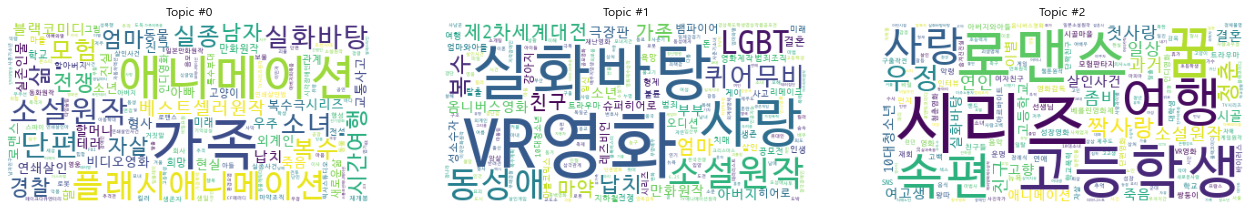

In [115]:
wc = WordCloud(background_color='white', font_path=font_path)            

plt.figure(figsize=(30,30))
for t in range(lda.num_topics):
    plt.subplot(5,4,t+1)
    x = dict(lda.show_topic(t,200))
    im = wc.generate_from_frequencies(x)
    plt.imshow(im)
    plt.axis("off")
    plt.title("Topic #" + str(t))

- 토픽을 3가지로 나눠서 분류했을 때, 
    - 1번째 토픽에서 **애니메이션, 가족** 키워드를 보아 가족을 주제로 한 애니메이션이 많을 것으로 파악된다.
    - 2번째 토픽에서 **실화바탕, 사랑, 소설원작** 키워드로 보아 실제 스토리를 소설화한 원작을 바탕으로 리메이크한 영화가 많을 것으로 파악된다.
    - 3번째 토픽에서 **로맨스, 시리즈, 고등학생, 여행, 꿈** 키워드를 보아 하이틴 소재를 한 영화가 많은 것으로 파악된다.

### 4. 네트워크 분석

In [116]:
import networkx as nx

# 영화 스토리 리스트화
story_sets = []
story = [word.split(',') for word in movie['content']]
for i in range(len(story)):
    nWord = [word for word in story[i] if word not in stopwords]
    story_sets.append(nWord)

In [134]:
## 연관규칙
from apyori import apriori

# 스토리별 단어 연관성 파악
result = list(apriori(story_sets, min_support = 0.01))
ass_df = pd.DataFrame(result)
ass_df['length'] = ass_df['items'].apply(lambda x:len(x))
ass_df = ass_df[(ass_df['length'] == 2)&(ass_df['support']>=0.01)].sort_values(by='support',ascending=False)
ass_df.head()

,items,support,ordered_statistics,length
26,"(속편, 시리즈)",0.014474,"[((), (속편, 시리즈), 0.014474107430041815, 1.0), (...",2
25,"(독립영화, 단편영화)",0.012802,"[((), (독립영화, 단편영화), 0.012801543904792538, 1.0)...",2


In [135]:
# 네트워크 그래프 정의
G = nx.Graph()
ar = (ass_df['items']); G.add_edges_from(ar)

In [136]:
# 패이지랭크: 노드 순위, 색상, 크기 지정 유용
pr = nx.pagerank(G)
nsize = np.array([v for v in pr.values()])
nsize = 2000 * (nsize-min(nsize))/(max(nsize)-min(nsize))

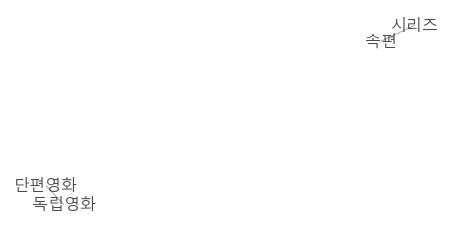

In [138]:
plt.figure(figsize = (8, 4))
plt.axis('off')
nx.draw_networkx(G, font_size = 16, font_family = font_name, node_color = list(pr.values()), 
                node_size = nsize, alpha = 0.7, edge_color = '.5', cmap = plt.cm.YlGn)
plt.show()

- 데이터 특성 상, 각 영화 줄거리가 줄글이 아닌 주요 단어로 있어 네트워크 분석이 불가능해 보인다.